# Detailed Posterior Predictive Checks for Models fitted with HDDM

Author: 
Nadja R. Ging-Jehli;

I am tremendously thankful for the valuable inputs from: Pranavan Chanthrakumar, Michael J. Frank, Guillaume Pagnier, Swarag Thaikkandi.

## ReadMe

This script was developed to perform posterior predictive checks (PPCs) for regression models fitted with the LAN extension within HDDM. However, the script can be modified to be applicable to models that do not include any regression equations (for model parameters) and/or to models that have been fitted outside the LAN extension but within HDDM.

Included are three different posterior predictive checks (subsequently referred to as PPC1 to PPC3). These three checks will help to visualize potential misfits of the model by **simultaneously considering response frequency and the entire RT distribution of each response frequency.** This is important because an examination of how well a model fits the data, should not only include fits for mean reaction times (RTs) or response frequency. Instead, since one of the key advantages of a DDM is that it simultaneously fits response frequency and the shape of the entire RT distribution, assessing model performance should also include such a fine-grained analysis. The differences and similarities between the three different PPCs will be explained for each PPC separately.

The exemplified model in this script includes regression equations for drift rates (v) and boundary separations (a) that include covariates (i.e., reward, aversion, conflict) that change on a trial-by-trial basis. Therefore, drift rates and boundary separation also changed on a trial-by-trial basis. To simplify illustrations of potential model misfits, it is useful to bin trials with similar covariates together. In this example, we want to bin trials together based on the strength of the evidence for a particular response option. Note that the choice of how to bin trials together varies from study to study. In this script, we refer to this auxiliary categorical variable as **evidence condition (evd_cond).** It is based on the dichotomization of the continuous variable that has been used as covariates in the regression model. The goal is to split the data based on that categorical variable. We then create predictions for each category to see whether the model recovers behavioral patterns for each of this category. 

IMPORTANT: The regression model is not defined based on this categorical variable (evd_cond) - this is simply a way to plot the predictions/data!!! If someone has used a simpler model without any regression equations, this categorical "evd_cond"-variable could be replaced by another variable that defines the task conditions.

Below, you will see that we first split the data into **evidence condition (evd_cond)** quantiles based on single-trial evidence values. Note that this is simply done for illustration purposes. This means, the model has not been fitted to these evd_cond, but rather included the single-trial evidence values. evd_cond is defined as `sub_reward - sub_averse`. 

To simulate behavior of our model, we use parameter values that come from the posterior distribution traces of our model (we sample across the whole distribution for PPC 1 and PPC2. For PPC3, we use the posterior means to simulate model predictions that are then compared with the actual data. For all three PPCs, we use reward and averse values that come from the distribution of reward and averse values in the *actual data*. 

1. Adjustments will be necessary - particular locations are marked with @@@ in the script.

2. The script contains three different posterior predictive checks labeled as PPC1, PPC2, and PPC3. Each of these PPCs provide another perspective on the relationship between predictions and actual data, helping to detect potential misfits. Find more details on the PPC generation in their corresponding sections.



## Import modules/prepare enviroment

In [ ]:
## if you need to do this
# on oscar, if the environment is set up correctly, this is not needed
#!pip install git+https://github.com/hddm-devs/kabuki
#!pip install git+https://github.com/hddm-devs/hddm

## not needed (just in case you collaborate with others and you want to share results)
#from google.colab import drive
#drive.mount('/content/drive')

## Data management
import pandas as pd
import numpy as np
import pickle
import sys
import pickle
import kabuki
from kabuki.analyze import gelman_rubin
from scipy import stats
import seaborn as sns
import pymc

## Plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg') ## additionally added from Swaran's script
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.display.max_columns = None
from patsy import dmatrix #for generation of (regression) design matrices
from pandas import Series #to manipulate data-frames generated by hddm

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.markers as markers

import subprocess
import pymc.progressbar as pbar
import IPython

## Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

## HDDM
import hddm
from hddm.simulators.hddm_dataset_generators import simulator_h_c

## important to simulate prediction:
from hddm.simulators import simulator

## Provide labels and folder structures

In [ ]:
## Provide project name and model name. 
# the subsequent plots and files will include the model name and will be stored in the folder project. 
# so make sure, you have a folder that is labeled with the project name provided below.
# @@@: Manual adjustment necessary
project = 'Testing_PPCscript_v2'
mOutput_name = 'EMU_Angle25R_v8_log_N17'
name_datafile = 'EMU_data_cleaned_110422'
folder_modeloutput = 'results_mainModels2'

## if you want to check traces
#traces = hddm.load_csv('./'+folder_modeloutput+'/'+mOutput_name+'_traces.csv')
#traces.head()

## if you want to check data
#data_all = hddm.load_csv('./'+name_datafile+'.csv')
#data_all.head()

## Initialize the Setting for Posterior Predictive Checks (PPCs)

In [ ]:
## This dataframe will store predictions and actual data that have been sampled during the simulation
ppc_all = pd.DataFrame()


## Provide some specifications for the simulation
# define how many trials per subject and per evd_cond (i.e., your dichotomized continuous variable) you wanna simulate
# ideally, you use a large enough number of simulations so that you are really sampling from the entire distribution of task trials.
nSimBySBJbyEvdCond = 501


## define the model that the simulator should use (e.g., the model you used for the fitting procedure)
# if you use the "classical DDM" outside of the LAN extension, then just name it "classical ddm".
# below, the generator of simulated data will then need to be adjusted accordingly.
# I included a note at the corresponding location below.
model='angle'

## Load the traces
traces = hddm.load_csv('./'+folder_modeloutput+'/'+mOutput_name+'_traces.csv')


######################## Provide Covariates

## Define Covariates from regression equations (i.e., the variables that will be put out from the datafile):
cov1_label = 'sub_averse'
cov2_label = 'conflictDomainD'
cov3_label = 'sub_rewardLOG'
cov4_label = 'sub_conflict'
# initialize variables (this is not really necessary, but it helps to think about the equations that are specified below):
cov1 = 0
cov2 = 0
cov3 = 0
cov4 = 0


######################## Provide the set of parameters 

### Boundary separation (a)
a_name1 = 'a_Intercept_subj.' 
a_name2 = 'a_conflictDomain[T.pos]_subj.'
a_name3 = 'a_sub_conflict_subj.' 
a_name4 = 'a_sub_conflict:conflictDomain[T.pos]_subj.'
# initialize variables (this is not really necessary, but it helps to think about the equations that are specified below):
a_1 = 0
a_2 = 0
a_3 = 0
a_4 = 0


### Starting points (z)
# IMPORTANT: only the intercept will need to be transformed!!!
# Specifically, if variable in traces has ending "_trans", then you need to transform it back.
z_name1 = 'z_Intercept_subj_trans.'  
# initialize variables (this is not really necessary, but it helps to think about the equations that are specified below):
z_1 = 0

### Boundary collapse (theta). this is specific to the angle model    
theta_name1 = 'theta_Intercept_subj.'
#theta_name2 = 'theta_conflictDomain[T.pos]_subj.'
#theta_name3 = 'theta_sub_conflict_subj.'  
# initialize variables (this is not really necessary, but it helps to think about the equations that are specified below):
theta_1 = 0

                      
### Nondecision time (t)
t_name1 = 't_Intercept_subj.'  
# initialize variables (this is not really necessary, but it helps to think about the equations that are specified below):
t_1 = 0


### Drift rate (v)
v_name1 = 'v_Intercept_subj.'
v_name2 = 'v_conflictDomain[T.pos]_subj.'
v_name3 = 'v_sub_rewardLOG_subj.'
v_name4 = 'v_sub_rewardLOG:conflictDomain[T.pos]_subj.'
v_name5 = 'v_sub_averse_subj.'
v_name6 = 'v_sub_averse:conflictDomain[T.pos]_subj.'
# initialize variables (this is not really necessary, but it helps to think about the equations that are specified below):
v_1 = 0
v_2 = 0
v_3 = 0
v_4 = 0
v_5 = 0
v_6 = 0


## Prepare the datafile

In [ ]:
## Load datafile and traces
data_all = hddm.load_csv('./'+name_datafile+'.csv')
   # data_all['condition'] = 'pre': this is just for nadja to test code



## Define RT column (must) 
# define column that has the RTs that was used for model fitting 
# (so with neg. signs for hitting lower boundary and positive signs for hitting upper boundary)
# it is important to have and declare in the script the column of 'signedRTs' 
# even though it's technically not necessarily the same column that the model was fit to (since hddm always fits to rt column)
data_all['RTppc'] = data_all['dt25']


## Optional Step:
# in case you wanna exclude any subjects (e.g., if you don't have data for both ws_cond), this can be done here
# data_all=data_all[data_all.subj_idx!=33]


## Optional Step:
# convert categorical variables (strings) to dummies (can be better handled in the equation below)
# you need to compare data and traces to see in the traces which condition HDDM took as the baseline condition.
# The baseline condition should then be coded as zero.
# note, this is for regression equations where we specify interactions of independent variables (referred to as x) like this: 
# x1*x2. Note that this is not the same as a specification of x1:x2. 
# @ Pran: Elaborate more here on this.
# if-else R-version in python:
data_all['conflictDomainD'] = np.where(data_all['conflictDomain'] == 'neg', 0,1)


## Optional Step: 
# if you excluded faster RTs or slower RTs than a certain threshold in your modeling script, 
# you also want to exclude them here from the data (just add the constraints you potentially had in your modeling script)
data_all=data_all[data_all.RTppc>-10].reset_index() # this has already been done in the preprocessing step
data_all=data_all[data_all.RTppc<10].reset_index()


## Select within-subject-variable 
#(e.g., stressor-condition: pre/post or DBS on/off)
# if you wanna do this, then use other script: ppc_qqp_byEvdCond_byWsCond


#### *Reward Evidence Categorization (Steps 1-6)*
# We first calculate a 'Reward Evidence' value. 
# Here, we define it as `(sub_reward - sub_averse)`. 
# We then separate the trials based on which Reward Evidence quartile they fall into: 
# low (0-25%), medium (25-50%), higher (50-75%), and highest (75-100%).

## Define "EvdCond" and dichotomize your continuous variable. 
# this will be used to split the data into different categories
# ppc will then be performed for each of these categories
# This dichotomized variable is what we refer to as "evd_cond"   
# we initialize this variable as follows:
data_all['evd_cond'] = 999 # initialize the discrete variables

# specify here the variable which you want to use as "EvdCond" 
# (i.e., the variable that will be dichotomized to represent the fits for each category
data_all['RelRewEvid'] = data_all['sub_reward'] - data_all['sub_averse']


## Define whether quartiles should be globally defined or locally (i.e., for each subject separately)
# gl=1 means: yes, define the bins of task trials globally across all subjects; 
# gl=0 means: no, define the bins of task trials locally for each subject separately
gl=0 

if gl == 1:
    # this defines the quartiles that serve as cutoffs to create categories with equal nr of observations 
    # you could also use percentiles or tertiles, which might slow-down or speed-up the simulations.
    q1 = np.percentile(data_all['RelRewEvid'], 25)
    q2 = np.percentile(data_all['RelRewEvid'], 50)
    q3 = np.percentile(data_all['RelRewEvid'], 75)

    for index, row in data_all.iterrows():
        if row['RelRewEvid'] <= q1:
            row['evd_cond'] = 'low'
            data_all.loc[index, 'evd_cond'] = 'low'
        elif q1 < row['RelRewEvid'] <= q2:
            row['evd_cond'] = 'medium'
            data_all.loc[index, 'evd_cond'] = 'medium'
        elif q2 < row['RelRewEvid'] <= q3:
            row['evd_cond'] = 'higher'
            data_all.loc[index, 'evd_cond'] = 'higher'
        else:
            row['RelRewEvid'] = 'highest'
            data_all.loc[index, 'evd_cond'] = 'highest'
            
            
if gl == 0:
    subjs=np.unique(np.array(data_all.subj_idx))
    data2 = pd.DataFrame()
    
    for sbj in subjs:
        data_sub = data_all[data_all.subj_idx==sbj].reset_index(drop=True)
        
        q1sb = np.percentile(data_sub['RelRewEvid'], 25)
        q2sb = np.percentile(data_sub['RelRewEvid'], 50)
        q3sb = np.percentile(data_sub['RelRewEvid'], 75)
        
    ## Calculate evd_cond (if gl=0 which means that quartiles should be created at subject-specific levels)
        for index, row in data_sub.iterrows():
            if row['RelRewEvid'] <= q1sb:
                row['evd_cond'] = 'low'
                data_sub.loc[index, 'evd_cond'] = 'low'
            elif q1sb < row['RelRewEvid'] <= q2sb:
                row['evd_cond'] = 'medium'
                data_sub.loc[index, 'evd_cond'] = 'medium'
            elif q2sb < row['RelRewEvid'] <= q3sb:
                row['evd_cond'] = 'higher'
                data_sub.loc[index, 'evd_cond'] = 'higher'
            else:
                row['RelRewEvid'] = 'highest'
                data_sub.loc[index, 'evd_cond'] = 'highest'
                
        data2 = data2.append(data_sub,ignore_index=True)

#data2.head()


if gl == 1:
    data_sc = data_all
    
if gl == 0:
    data_sc = data2

## Posterior Predictive Check 1 (PPC1)

### Description

PPC 1 consists of:
1. a simple RT distribution graph with our actual data plotted in blue and the RT's predicted by our model plotted in red. 
2. a quantile-proability plot with actual data plotted as squares and predicted data plotted as crosses.

#### *Create Response & RT Predictions from Model (Steps 7-8)*

Next, to simulate the behavior of our model, we do the following: 
* From the ***posterior distributions contained in our traces***, we sample values for our parameters of interest (intercepts and coefficients for each of the covariates in our regression equations).
* From the ***distribution of reward and averse values in the actual data***, we sample values for the reward and averse offered on a trial. (See note below.)
* Using the sampled values for parameters of interest and the sampled values for reward and averse on a given trial, we can input these into the regression equations that characterize our model. This will ***yield predicted values for response and RT***.

#### *Note on Rew/Ave Sampling* 
Since we use reward evidence *quartiles* to split the data, we can guarantee that there will be a similar number of trials of the ***actual data*** in each quartile. When we simulate our model results, we don't want to sample reward and averse values from the data ***as a whole***, since this could lead to differing number of simulation trials in each reward evidence quartile. To avoid this, we split the actual data's trials into four reward evidence quartiles, and then sample reward/averse the same number of times from ***each quartile***. This ensures that we have a similar number of simulated trials (and associated sampled rew/ave combinations) that fall into each reward evidence *quartile*.

#### *Note on Signed RT's*

In the below code, in step 7.3, rt_dat is set to a specific column of our data. For the PPC plot to display accurately, this column should have signed RT's, where avoid decisions have negative RT values and approach decisions have positive RT values.

#### *Note on Parameter Definitions*

In the below code, in steps 7.5 & 7.6, you will have to manually ensure that all your parameters are defined, even if they don't vary by anything except intercept! It would be incorrect to only define the parameters that you are interested in or that you are creating interesting covariates for - don't do this!

In [ ]:
## Step 7. Set up simulation to sample n times (i.e., defined above by: nSimBySBJbyEvdCond) for each subject and evd_cond
evd_conds=['low','medium','higher','highest']
subjs=np.unique(np.array(data_sc.subj_idx))


for evidence_cond in evd_conds:
    for sbj in subjs: 
        ## Step 7.1. select subject and evd_cond
        data=data_sc[data_sc.subj_idx==sbj]
        sdf = data[data.evd_cond==evidence_cond].reset_index(drop=True)
               
        # start simulation loop
        for i in range(1,nSimBySBJbyEvdCond):
            
            # result of each iteration will be stored in ppc_low. This is just an auxiliary dataframe. 
            # Everything will be stored in ppc_all at the end
            ppc_low = pd.DataFrame()
            sample = i # counter used for the dataframe    
    
            ## Step 7.2. randomly sample a trial from the dataset for which we want to generate predictions
            sampleDat = np.random.randint(0,sdf.shape[0])

            ## Step 7.3. extract the required data of that sampled trial
            #   convert reward_dat and aversion_dat from pandas.dataframe to numpy.floating number. 
            #   Needed for the model parameters below.
            #   @@@: manual adjustment necessary
            cov1 = sdf.iloc[sampleDat][cov1_label].astype('float64')  
            cov2 = sdf.iloc[sampleDat][cov2_label].astype('float64')
            cov3 = sdf.iloc[sampleDat][cov3_label].astype('float64')
            cov4 = sdf.iloc[sampleDat][cov4_label].astype('float64') 
            
            resp_dat = sdf.iloc[sampleDat]['response'].astype('int64')  
            rt_dat = sdf.iloc[sampleDat]['RTppc'].astype('float64')  
            
            ## Step 7.4. randomly select a sample from the trace
            sampleTr = np.random.randint(0,traces.shape[0]) #np.random.randint(0,traces.shape[0]-1)
            # print(sampleTr)

            ## Step 7.5. extract the estimated parameters for that subject
            # based on how you defined your regression models, you will have different equations
            #   @@@: manual adjustment necessary
            # Extract parameters of boundary separation (a)
            a_1 = traces.loc[sampleTr,a_name1+str(sbj)].astype('float64') 
            a_2 = traces.loc[sampleTr,a_name2+str(sbj)].astype('float64')
            a_3 = traces.loc[sampleTr,a_name3+str(sbj)].astype('float64') 
            a_4 = traces.loc[sampleTr,a_name4+str(sbj)].astype('float64') 
                        
            # Extract parameters of starting points (z)
            # IMPORTANT: only the intercept will need to be transformed!!!
            # Specifically, if variable in traces has ending "_trans", then you need to transform it back.
            z_1 = 1/(1+np.exp(-1*traces.loc[sampleTr,z_name1+str(sbj)].astype('float64')))    ## do we have to transform this back?
                       
            # Extract parameters of boundary collapse (theta). this is specific to the angle model    
            theta_1 = traces.loc[sampleTr,theta_name1+str(sbj)].astype('float64')
            #theta_2 = traces.loc[sampleTr,theta_name2+str(sbj)].astype('float64')
            #theta_3 = traces.loc[sampleTr,theta_name3+str(sbj)].astype('float64')  
                      
            # Extract parameters of nondecision time (t)
            t_1 = traces.loc[sampleTr,t_name1+str(sbj)].astype('float64')  

            # Extract parameters of drift rate (v)
            v_1 = traces.loc[sampleTr,v_name1+str(sbj)].astype('float64')  
            v_2 = traces.loc[sampleTr,v_name2+str(sbj)].astype('float64')
            v_3 = traces.loc[sampleTr,v_name3+str(sbj)].astype('float64')  
            v_4 = traces.loc[sampleTr,v_name4+str(sbj)].astype('float64')
            v_5 = traces.loc[sampleTr,v_name5+str(sbj)].astype('float64')  
            v_6 = traces.loc[sampleTr,v_name6+str(sbj)].astype('float64')

                    
            ## Step 7.6. form the required parameter vector to generate predictions
            #   @@@: manual adjustment necessary
            V = v_1 + v_2*cov2 + v_3*cov3 + v_4*cov3*cov2 + v_5*cov1 + v_6*cov1*cov2
            #print('V:',V)
            V = V.astype('float64')  
            a = a_1 + a_2*cov2 + a_3*cov4 + a_4*cov2*cov4
            a = a.astype('float64')
            z = z_1
            z = z.astype('float64')
            t = t_1
            t = t.astype('float64')
            thetaP = theta_1
            thetaP = thetaP.astype('float64')
                            
            ## Step 7.7. create vector of params that will be fed into the simulator
            # @@@ manual adjustment necessary
            # make sure the order is correct - it needs to match what you were using for the model fitting procedure
            # use this to see the sequence of parameters for each model to feed into
            # order of params for angle model: ['v', 'a', 'z', 't', 'theta']
            # see: hddm.simulators.model_config
            params_temp = [V,a,z,t,thetaP]  

    
            ## Step 7.8. generate prediction (1 prediction per iteration)
            # if you don't use the LAN extension, you will want to use the simulator-function from the classical HDDM module
            out = simulator(model = model,
                            theta = params_temp,
                            n_samples = 1,
                            delta_t = 0.001)
            rt_pred = out[0][0].astype('float64')  
            resp_pred = out[1][0]

            ## Step 7.9. store stuff in temporary dataframe (will be appended to ppc_all below)
            # @@@ manual adjustment necessary for: reward, aversion
            ppc_low = pd.DataFrame({'sample': [sample],
                                    'sbj': [sbj],
                                    'reward': [cov3],
                                    'aversion': [cov1],
                                    'conflict': [cov4],
                                    'cdDummy': [cov2],
                                    'resp_data': [resp_dat],
                                    'rt_data': [rt_dat],
                                    'resp_pred': [1*(resp_pred[0]>0)],
                                    'rt_pred': [np.sign(resp_pred[0])*rt_pred[0]],
                                    'evidence_cond':evidence_cond})
            ## append the stuff 
            #print('subject is:',sbj)
            ppc_all = ppc_all.append(ppc_low,ignore_index=True)

## Step 8. store everything
# so next time, you can simply load the .csv file instead of re-running the entire simulation again. 
ppc_all.to_csv('./'+project+'_'+mOutput_name+'_ppc1_byEvdCond.csv')
# ppc_all.head() 


In [38]:
## in case you have already run the simulation above and stored the csv file, you can use this now:
ppc_all = hddm.load_csv('./'+project+'_'+mOutput_name+'_ppc1_byEvdCond.csv')
ppc_all.head() 

,Unnamed: 0,sample,sbj,reward,aversion,conflict,cdDummy,resp_data,rt_data,resp_pred,rt_pred,evidence_cond
0,0,1,60,-1.270536,0.976349,-0.535465,0.0,1,1.801,0,-1.634572,low
1,1,2,60,-1.270536,0.976349,-0.535465,0.0,0,-2.070,0,-3.301794,low
2,2,3,60,-1.270536,0.594901,-0.136301,0.0,1,1.520,0,-2.955881,low
3,3,4,60,-1.270536,0.976349,-0.535465,0.0,0,-1.697,1,1.115010,low
4,4,5,60,-1.270536,0.976349,-0.535465,0.0,0,-2.350,0,-1.439636,low


In [39]:
# show header of dataframe: (just for illustration purposes)
#data_sc.head()

### Plotting Results of Posterior Predictive Check 1

The code below plots the distributions by evd_cond (aggr across all subjects) for data (in blue) and for predictions (in red).

Text(0.5, 1.0, 'evd_cond: highest')

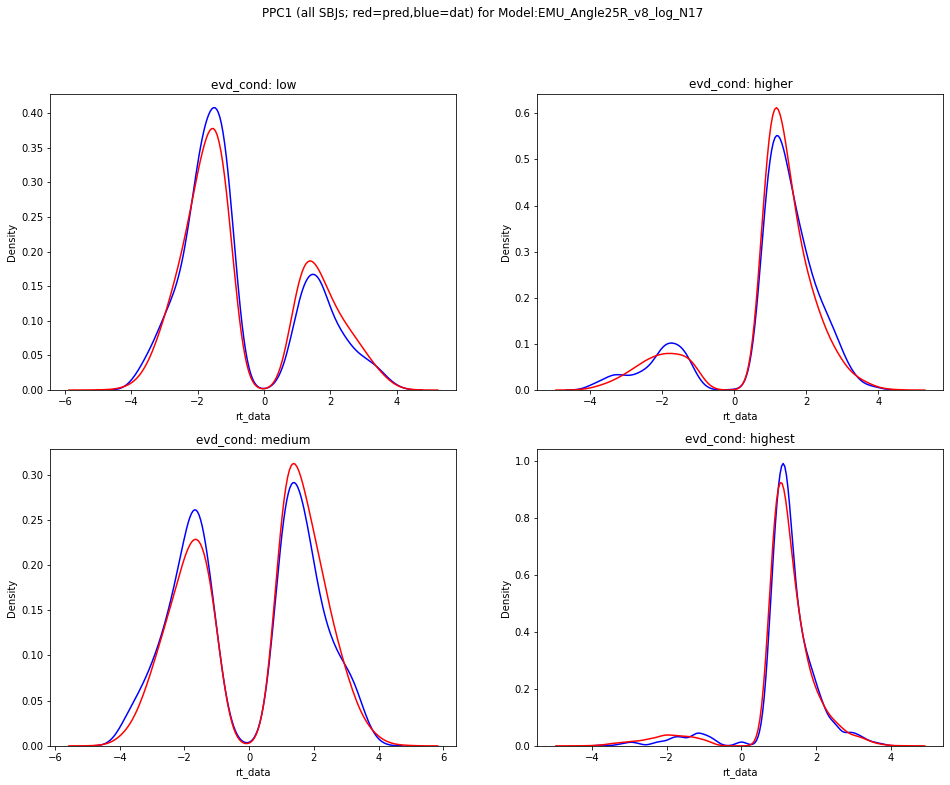

In [40]:

ppc_sub = ppc_all

ppc_cond1=ppc_sub[ppc_sub.evidence_cond=='low']
ppc_cond2=ppc_sub[ppc_sub.evidence_cond=='medium']
ppc_cond3=ppc_sub[ppc_sub.evidence_cond=='higher']
ppc_cond4=ppc_sub[ppc_sub.evidence_cond=='highest']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.suptitle('PPC1 (all SBJs; red=pred,blue=dat) for Model:'+mOutput_name)

sns.kdeplot(data=ppc_cond1, x='rt_data', color='b', ax=axes[0, 0])
sns.kdeplot(data=ppc_cond1, x='rt_pred',color='r', ax=axes[0, 0])
axes[0,0].set_title('evd_cond: low')

sns.kdeplot(data=ppc_cond2, x='rt_data', color='b', ax=axes[1, 0])
sns.kdeplot(data=ppc_cond2, x='rt_pred',color='r', ax=axes[1, 0])
axes[1,0].set_title('evd_cond: medium')

sns.kdeplot(data=ppc_cond3, x='rt_data', color='b', ax=axes[0, 1])
sns.kdeplot(data=ppc_cond3, x='rt_pred',color='r', ax=axes[0, 1])
axes[0,1].set_title('evd_cond: higher')

sns.kdeplot(data=ppc_cond4, x='rt_data', color='b', ax=axes[1, 1])
sns.kdeplot(data=ppc_cond4, x='rt_pred',color='r', ax=axes[1, 1])
axes[1,1].set_title('evd_cond: highest')



### Quantile-Probability Plot for PPC1

In [41]:

# for each subject, calculate the quantiles for each RelRewEvid-condition:
evd_conds=['low','medium','higher','highest']

subjs=np.unique(np.array(ppc_all.sbj))
qcBySBJ_ppc1DAT = pd.DataFrame()
qcBySBJ_ppc1PRED = pd.DataFrame()

# convert RT measure into milliseconds and get rid of sign:
ppc_all['rtp_data'] = abs(ppc_all['rt_data'])*1000
ppc_all['rtp_pred'] = abs(ppc_all['rt_pred'])*1000


###### Calculate quantiles for sampled data:


for evidence_cond in evd_conds:
    for sbj in subjs:
        ## Step 1. select the subject and the condition
        df=ppc_all[ppc_all.sbj==sbj]
        dfsub = df[df.evidence_cond==evidence_cond].reset_index(drop=True)
        ntrials = dfsub.shape[0] #nr of obs. for that subject and that condition
        aux = pd.DataFrame()
        
        ## Step 2. subset data by response type
        dfsub_R1 = dfsub[dfsub.resp_data==1].reset_index(drop=True) # response type 1: decisions towards upper boundary
        dfsub_R2 = dfsub[dfsub.resp_data==0].reset_index(drop=True) # response type 2: decisions towards lower boundary
        
        ## Step 3. calculate quantiles for each subset
        if not dfsub_R1.empty:
            Freq_R1 = dfsub_R1.shape[0]/ntrials #nr of rows
            q1_R1 = np.percentile(dfsub_R1['rtp_data'], 10)
            q3_R1 = np.percentile(dfsub_R1['rtp_data'], 30)
            q5_R1 = np.percentile(dfsub_R1['rtp_data'], 50)
            q7_R1 = np.percentile(dfsub_R1['rtp_data'], 70)
            q9_R1 = np.percentile(dfsub_R1['rtp_data'], 90)
        else: # if subject does not have any responses in response category 1
            Freq_R1 = 0
            q1_R1 = np.nan
            q3_R1 = np.nan
            q5_R1 = np.nan
            q7_R1 = np.nan
            q9_R1 = np.nan
            
        if not dfsub_R2.empty:
            Freq_R2 = dfsub_R2.shape[0]/ntrials #nr of rows
            q1_R2 = np.percentile(dfsub_R2['rtp_data'], 10)
            q3_R2 = np.percentile(dfsub_R2['rtp_data'], 30)
            q5_R2 = np.percentile(dfsub_R2['rtp_data'], 50)
            q7_R2 = np.percentile(dfsub_R2['rtp_data'], 70)
            q9_R2 = np.percentile(dfsub_R2['rtp_data'], 90)
        else: # if subject does not have any responses in response category 1
            Freq_R2 = 0
            q1_R2 = np.nan
            q3_R2 = np.nan
            q5_R2 = np.nan
            q7_R2 = np.nan
            q9_R2 = np.nan
        
        ## Step 4. store stuff in newly created pandas dataframe that we can then use later
        aux = pd.DataFrame({'sbj': [sbj],
                            'evidence_cond': evidence_cond,
                            'FreqR1':Freq_R1,
                            'FreqR2':Freq_R2,
                            'q1_R1': q1_R1,
                            'q3_R1': q3_R1,
                            'q5_R1': q5_R1,
                            'q7_R1': q7_R1,
                            'q9_R1': q9_R1,
                            'q1_R2': q1_R2,
                            'q3_R2': q3_R2,
                            'q5_R2': q5_R2,
                            'q7_R2': q7_R2,
                            'q9_R2': q9_R2})
       
        ## Step 5. append the stuff 
        #print('subject is:',sbj)
        qcBySBJ_ppc1DAT = qcBySBJ_ppc1DAT.append(aux,ignore_index=True)



        
###### Calculate quantiles for sampled predictions:

for evidence_cond in evd_conds:
    for sbj in subjs:
        ## Step 1. select the subject and the condition
        df=ppc_all[ppc_all.sbj==sbj]
        dfsub = df[df.evidence_cond==evidence_cond].reset_index(drop=True)
        ntrials = dfsub.shape[0] #nr of obs. for that subject and that condition
        aux_pred = pd.DataFrame()
        
        ## Step 2. subset data by response type
        dfsub_R1 = dfsub[dfsub.resp_pred==1].reset_index(drop=True) # approach decisions
        dfsub_R2 = dfsub[dfsub.resp_pred==0].reset_index(drop=True) # avoid decisions
        
        ## Step 3. calculate quantiles for each subset
        if not dfsub_R1.empty:
            Freq_R1 = dfsub_R1.shape[0]/ntrials #nr of rows
            q1_R1 = np.percentile(dfsub_R1['rtp_pred'], 10)
            q3_R1 = np.percentile(dfsub_R1['rtp_pred'], 30)
            q5_R1 = np.percentile(dfsub_R1['rtp_pred'], 50)
            q7_R1 = np.percentile(dfsub_R1['rtp_pred'], 70)
            q9_R1 = np.percentile(dfsub_R1['rtp_pred'], 90)
        else:
            Freq_R1 = 0
            q1_R1 = np.nan
            q3_R1 = np.nan
            q5_R1 = np.nan
            q7_R1 = np.nan
            q9_R1 = np.nan
            
        if not dfsub_R2.empty:
            Freq_R2 = dfsub_R2.shape[0]/ntrials #nr of rows
            q1_R2 = np.percentile(dfsub_R2['rtp_pred'], 10)
            q3_R2 = np.percentile(dfsub_R2['rtp_pred'], 30)
            q5_R2 = np.percentile(dfsub_R2['rtp_pred'], 50)
            q7_R2 = np.percentile(dfsub_R2['rtp_pred'], 70)
            q9_R2 = np.percentile(dfsub_R2['rtp_pred'], 90)
        else:
            Freq_R2 = 0
            q1_R2 = np.nan
            q3_R2 = np.nan
            q5_R2 = np.nan
            q7_R2 = np.nan
            q9_R2 = np.nan
        
        ## Step 4. store stuff in newly created pandas dataframe that we can then use later
        aux_pred = pd.DataFrame({'sbj': [sbj],
                                 'evidence_cond': evidence_cond,
                                 'FreqR1':Freq_R1,
                                 'FreqR2':Freq_R2,
                                 'q1_R1': q1_R1,
                                 'q3_R1': q3_R1,
                                 'q5_R1': q5_R1,
                                 'q7_R1': q7_R1,
                                 'q9_R1': q9_R1,
                                 'q1_R2': q1_R2,
                                 'q3_R2': q3_R2,
                                 'q5_R2': q5_R2,
                                 'q7_R2': q7_R2,
                                 'q9_R2': q9_R2})
            
        ## Step 5. append the stuff 
        #print('subject is:',sbj)
        qcBySBJ_ppc1PRED = qcBySBJ_ppc1PRED.append(aux_pred,ignore_index=True)
    



In [42]:
###### Calculate statistics across subjects

## Calculate the means of each quantile (once for data and once for predictions)
qc_ppc1DAT = qcBySBJ_ppc1DAT.groupby(['evidence_cond']).mean() #.reset_index(name='evidence_cond')
qc_ppc1DAT['evidence_cond'] = ['higher','highest','low','medium']
tt_ppc1DAT = qc_ppc1DAT.reset_index(drop=True) 

qc_ppc1PRED = qcBySBJ_ppc1PRED.groupby(['evidence_cond']).mean() #.reset_index(name='evidence_cond')
qc_ppc1PRED['evidence_cond'] = ['higher','highest','low','medium']
tt_ppc1PRED = qc_ppc1PRED.reset_index(drop=True) 
      
    
## Calculate the SDs of each quantile (once for data and once for predictions)
sdqc_ppc1DAT = qcBySBJ_ppc1DAT.groupby(['evidence_cond']).std() #.reset_index(name='evidence_cond')
sdqc_ppc1DAT['evidence_cond'] = ['higher','highest','low','medium']
sdtt_ppc1DAT = sdqc_ppc1DAT.reset_index(drop=True) 

sdqc_ppc1PRED = qcBySBJ_ppc1PRED.groupby(['evidence_cond']).std() #.reset_index(name='evidence_cond')
sdqc_ppc1PRED['evidence_cond'] = ['higher','highest','low','medium']
sdtt_ppc1PRED = sdqc_ppc1PRED.reset_index(drop=True) 


Text(0.5, 1.0, 'squares: data, +: pred (filled:Ap, unfilled: Av)')

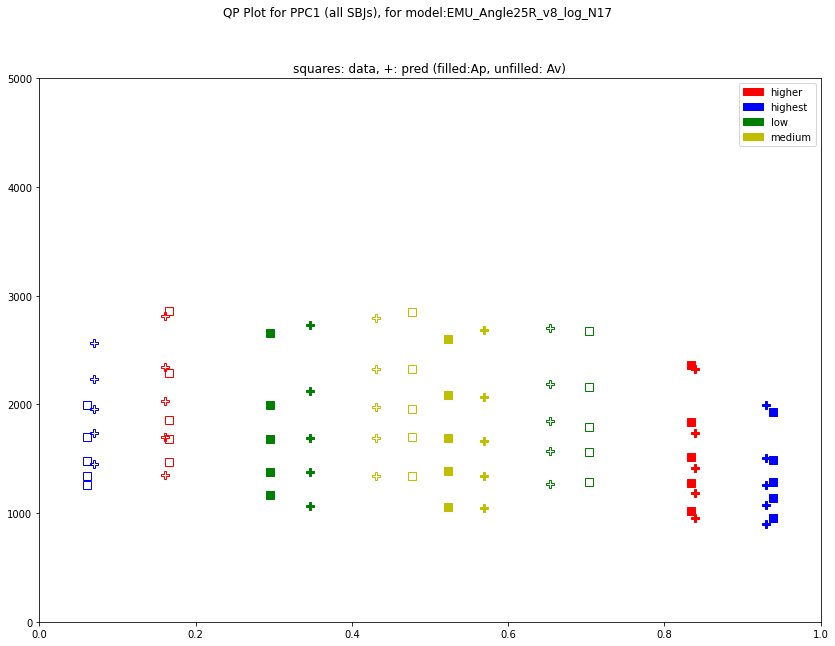

In [43]:
###### do the plotting


colors = ['ro','bo','go','yo']
n=4

fig, ax = plt.subplots(figsize=(14,10)) #figsize: width, height

markerR1 = markers.MarkerStyle(marker='s', fillstyle='full')
markerR2 = markers.MarkerStyle(marker='s', fillstyle='none')
markerR3 = markers.MarkerStyle(marker='P', fillstyle='full')
markerR4 = markers.MarkerStyle(marker='P', fillstyle='none')

MarkerSizePoints = 8

for ind in range(n):
    col = colors[ind]
    ax.plot(tt_ppc1DAT['FreqR1'].loc[tt_ppc1DAT.index[ind]], [tt_ppc1DAT['q1_R1'].loc[tt_ppc1DAT.index[ind]]], col, marker=markerR1,markersize=MarkerSizePoints)
    ax.plot(tt_ppc1DAT['FreqR1'].loc[tt_ppc1DAT.index[ind]], [tt_ppc1DAT['q3_R1'].loc[tt_ppc1DAT.index[ind]]], col, marker=markerR1,markersize=MarkerSizePoints)
    ax.plot(tt_ppc1DAT['FreqR1'].loc[tt_ppc1DAT.index[ind]], [tt_ppc1DAT['q5_R1'].loc[tt_ppc1DAT.index[ind]]], col, marker=markerR1,markersize=MarkerSizePoints)
    ax.plot(tt_ppc1DAT['FreqR1'].loc[tt_ppc1DAT.index[ind]], [tt_ppc1DAT['q7_R1'].loc[tt_ppc1DAT.index[ind]]], col, marker=markerR1,markersize=MarkerSizePoints)
    ax.plot(tt_ppc1DAT['FreqR1'].loc[tt_ppc1DAT.index[ind]], [tt_ppc1DAT['q9_R1'].loc[tt_ppc1DAT.index[ind]]], col, marker=markerR1,markersize=MarkerSizePoints)
    
    ax.plot(tt_ppc1DAT['FreqR2'].loc[tt_ppc1DAT.index[ind]], [tt_ppc1DAT['q1_R2'].loc[tt_ppc1DAT.index[ind]]], col, marker=markerR2,markersize=MarkerSizePoints)
    ax.plot(tt_ppc1DAT['FreqR2'].loc[tt_ppc1DAT.index[ind]], [tt_ppc1DAT['q3_R2'].loc[tt_ppc1DAT.index[ind]]], col, marker=markerR2,markersize=MarkerSizePoints)
    ax.plot(tt_ppc1DAT['FreqR2'].loc[tt_ppc1DAT.index[ind]], [tt_ppc1DAT['q5_R2'].loc[tt_ppc1DAT.index[ind]]], col, marker=markerR2,markersize=MarkerSizePoints)
    ax.plot(tt_ppc1DAT['FreqR2'].loc[tt_ppc1DAT.index[ind]], [tt_ppc1DAT['q7_R2'].loc[tt_ppc1DAT.index[ind]]], col, marker=markerR2,markersize=MarkerSizePoints)
    ax.plot(tt_ppc1DAT['FreqR2'].loc[tt_ppc1DAT.index[ind]], [tt_ppc1DAT['q9_R2'].loc[tt_ppc1DAT.index[ind]]], col, marker=markerR2,markersize=MarkerSizePoints)
    
    ax.plot(tt_ppc1PRED['FreqR1'].loc[tt_ppc1PRED.index[ind]], [tt_ppc1PRED['q1_R1'].loc[tt_ppc1PRED.index[ind]]], col, marker=markerR3,markersize=MarkerSizePoints)
    ax.plot(tt_ppc1PRED['FreqR1'].loc[tt_ppc1PRED.index[ind]], [tt_ppc1PRED['q3_R1'].loc[tt_ppc1PRED.index[ind]]], col, marker=markerR3,markersize=MarkerSizePoints)
    ax.plot(tt_ppc1PRED['FreqR1'].loc[tt_ppc1PRED.index[ind]], [tt_ppc1PRED['q5_R1'].loc[tt_ppc1PRED.index[ind]]], col, marker=markerR3,markersize=MarkerSizePoints)
    ax.plot(tt_ppc1PRED['FreqR1'].loc[tt_ppc1PRED.index[ind]], [tt_ppc1PRED['q7_R1'].loc[tt_ppc1PRED.index[ind]]], col, marker=markerR3,markersize=MarkerSizePoints)
    ax.plot(tt_ppc1PRED['FreqR1'].loc[tt_ppc1PRED.index[ind]], [tt_ppc1PRED['q9_R1'].loc[tt_ppc1PRED.index[ind]]], col, marker=markerR3,markersize=MarkerSizePoints)
    
    ax.plot(tt_ppc1PRED['FreqR2'].loc[tt_ppc1PRED.index[ind]], [tt_ppc1PRED['q1_R2'].loc[tt_ppc1PRED.index[ind]]], col, marker=markerR4,markersize=MarkerSizePoints)
    ax.plot(tt_ppc1PRED['FreqR2'].loc[tt_ppc1PRED.index[ind]], [tt_ppc1PRED['q3_R2'].loc[tt_ppc1PRED.index[ind]]], col, marker=markerR4,markersize=MarkerSizePoints)
    ax.plot(tt_ppc1PRED['FreqR2'].loc[tt_ppc1PRED.index[ind]], [tt_ppc1PRED['q5_R2'].loc[tt_ppc1PRED.index[ind]]], col, marker=markerR4,markersize=MarkerSizePoints)
    ax.plot(tt_ppc1PRED['FreqR2'].loc[tt_ppc1PRED.index[ind]], [tt_ppc1PRED['q7_R2'].loc[tt_ppc1PRED.index[ind]]], col, marker=markerR4,markersize=MarkerSizePoints)
    ax.plot(tt_ppc1PRED['FreqR2'].loc[tt_ppc1PRED.index[ind]], [tt_ppc1PRED['q9_R2'].loc[tt_ppc1PRED.index[ind]]], col, marker=markerR4,markersize=MarkerSizePoints)

    ax.set_xlim(0,1)
    ax.set_ylim(0, 5000)

# Creating legend with color box
pop_a = mpatches.Patch(color='r', label='higher')
pop_b = mpatches.Patch(color='b', label='highest')
pop_c = mpatches.Patch(color='g', label='low')
pop_d = mpatches.Patch(color='y', label='medium')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d])
plt.suptitle("QP Plot for PPC1 (all SBJs), for model:"+mOutput_name) #Title
plt.title("squares: data, +: pred (filled:Ap, unfilled: Av)") #Subtitle


#### How to read the above quantile-probability plot (QP-plots)

Quantile probability plots simultaneously display response frequencies (along the x-axis) and quantiles of reaction times (along the y-axis) that approximate the entire RT distribution for each response frequency. This allows a more detailed investigation of the data and displays the relationship of response frequencies and RTs directly within one plot. The x-axis represents the response frequency of each response type and for each task condition (represented by different symbols and colors that are explained below). Response frequency of 0.5 means that people chose that given response option half the time. Along the y-axis are the RT quantiles (i.e., the 0.1, 0.3, 0.5, 0.7, and 0.9 quantile RTs) vertically plotted from bottom to top respectively.
In the plot above:
1. the four colors represent the four different task conditions - one for each of the evidence conditions (see definition on top of the script). 
2. Filled symbols represent the frequency of responses towards the upper boundary (in this case: "approach decisions"). Non-filled symbols represent the frequency of responses towards the lower boundary (in this case: "avoidance decisions").
3. the squares represent the actual data and the crosses represent the simulated data.

Note:
You always want to compute the RT-quantiles for each individual separately and then average across individuals. This is important because mathematically, taking the means of numbers is a non-linear operator (i.e., the order of operations matters).
There are some more details about this to find here:

Ratcliff, R. (1979). Group reaction time distributions and an analysis of distribution statistics. Psychological bulletin, 86(3), 446.


## Posterior Predictive Check 2 (PPC2)

### Description

PPC 2 creates a quantile-probability plot with actual data represented as squares and predicted data represented as crosses as well as ellipses that illustrate the uncertainty of the predictions. This is one of the main differences to PPC1.
Moreover, the approach on how we simulate the data is slightly different for PPC2 than for PPC1. 

For PPC1, we have just randomly selected one sample from the posterior distributions and one trial from the data to generate one simulated response and RT for the randomly selected trial. This is interesting but the comparison of simulated and actual data for a given evd_cond includes two different sources of variabilities: first, trials binned to a given evd_cond slightly differ from each other. Second, there is variability in the simulations due to the fact that we randomly sample from the posterior distributions (instead of using one point estimate for each model parameter to generate predictions). 

In PPC2, we focus on the second source of variability: we want to randomly sample from the posterior distribution but we want to ignore the variability that arises from the fact that trials differ within each evd_cond. We therefore, randomly select a set of model parameters to generate predictions across all the trials of a given evd_cond. 

Note that this PPC2 will take much longer than PPC1. You might want to adjust "nSimBySBJbyEvdCond_ppc2" which defines the number of samples drawn from the posterior distributions of model parameters.


In [ ]:
## Step 1. Configure PPC2
# nSimPPC1b determines the nr of RTs that are generated for each sample (i.e., simulation). 
# The RT-quantiles are computed for each simulation. So that nr shouldn't be too low.
nSimPPC2 = 400 
nSimBySBJbyEvdCond_ppc2 = 50 #100

## Step 2. this dataframe will store predictions and actual data that have been sampled during the simulation
ppc2_all = pd.DataFrame()
quantsByCondBySBJ_ppcDAT = pd.DataFrame()
quantsByCondBySBJ_ppcPRED = pd.DataFrame()


## Step 3. Set up simulation to sample n times (i.e., defined above by: nSimBySBJbyEvdCond) for each subject and evd_cond
evd_conds=['low','medium','higher','highest']
subjs=np.unique(np.array(data_sc.subj_idx))


## Step 4. start simulation loop
for i in range(1,nSimBySBJbyEvdCond_ppc2):
    
    sample = i # counter used for the dataframe
    
    ## randomly select a sample from the trace
    sampleTr = np.random.randint(0,traces.shape[0])
    
    for evidence_cond in evd_conds:
        
        for sbj in subjs: 
            
            ## Extract the estimated parameters for that subject
            
            # boundary separation (a)
            a_1 = traces.loc[sampleTr,a_name1+str(sbj)].astype('float64') 
            a_2 = traces.loc[sampleTr,a_name2+str(sbj)].astype('float64')
            a_3 = traces.loc[sampleTr,a_name3+str(sbj)].astype('float64') 
            a_4 = traces.loc[sampleTr,a_name4+str(sbj)].astype('float64') 
            
            # starting points (z)
            # IMPORTANT: only the intercept will need to be transformed!!!
            # Specifically, if variable in traces has ending "_trans", then you need to transform it back.
            z_1 = 1/(1+np.exp(-1*traces.loc[sampleTr,z_name1+str(sbj)].astype('float64')))               
            
            # Parameter of boundary collapse (theta). this is specific to the angle model    
            theta_1 = traces.loc[sampleTr,theta_name1+str(sbj)].astype('float64')
            #theta_2 = traces.loc[sampleTr,theta_name2+str(sbj)].astype('float64')
            #theta_3 = traces.loc[sampleTr,theta_name3+str(sbj)].astype('float64')      
            
            # nondecision time (t)
            t_1 = traces.loc[sampleTr,t_name1+str(sbj)].astype('float64')  
            
            # drift rate (v)
            v_1 = traces.loc[sampleTr,v_name1+str(sbj)].astype('float64')  
            v_2 = traces.loc[sampleTr,v_name2+str(sbj)].astype('float64')
            v_3 = traces.loc[sampleTr,v_name3+str(sbj)].astype('float64')  
            v_4 = traces.loc[sampleTr,v_name4+str(sbj)].astype('float64')
            v_5 = traces.loc[sampleTr,v_name5+str(sbj)].astype('float64')  
            v_6 = traces.loc[sampleTr,v_name6+str(sbj)].astype('float64')

        
            ## Select subject and evd_cond
            data=data_sc[data_sc.subj_idx==sbj]
            sdf = data[data.evd_cond==evidence_cond].reset_index(drop=True)
            
            ppc2_sample = pd.DataFrame() #dataframe to calculate quantiles by subject and evdCond
        
            ## Step 5. Extract the variables of each trial in evd_cond and simulate a prediction
            for index, row in sdf.iterrows():
                
                # result of each iteration will be stored in ppc_low. This is just an auxiliary dataframe. 
                # Everything will be stored in ppc_all at the end
                ppc_low = pd.DataFrame()
            
                trial = row['Trial']

                cov1 = row[cov1_label]
                cov2 = row[cov2_label]
                cov3 = row[cov3_label]
                cov4 = row[cov4_label] 
                
                resp_dat = row['response']  
                rt_dat = row['RTppc']
            
                ## Form the required parameter vector to generate predictions
                V = v_1 + v_2*cov2 + v_3*cov3 + v_4*cov3*cov2 + v_5*cov1 + v_6*cov1*cov2
                V = V.astype('float64')  
                a = a_1 + a_2*cov2 + a_3*cov4 + a_4*cov2*cov4
                a = a.astype('float64')
                z = z_1
                z = z.astype('float64')
                t = t_1
                t = t.astype('float64')
                thetaP = theta_1
                thetaP = thetaP.astype('float64')
            
                ## Create vector of params that will be fed into the simulator
                # make sure the order is correct - it needs to match what you were using for the model fitting procedure
                # use this to see the sequence of parameters for each model to feed into
                # order of params for angle model: ['v', 'a', 'z', 't', 'theta']
                # see: hddm.simulators.model_config
                params_temp = [V,a,z,t,thetaP]  

                ## Generate prediction (1 prediction per iteration)
                out = simulator(model = model,
                                theta = params_temp,
                                n_samples = 1,
                                delta_t = 0.001)
                rt_pred = out[0][0].astype('float64')  
                resp_pred = out[1][0]
            
                ## Step 6. Store stuff in temporary dataframe (will be appended to ppc_all below)
                # @@@ manual adjustment necessary for: reward, aversion
                ppc_low = pd.DataFrame({'evidence_cond':evidence_cond,
                                        'Trial':trial,
                                        'sample': [sample],
                                        'sbj': [sbj],
                                        'reward': [cov3],
                                        'aversion': [cov1],
                                        'conflict': [cov4],
                                        'cdDummy': [cov2],
                                        'resp_data': [resp_dat],
                                        'rt_data': [rt_dat],
                                        'resp_pred': [1*(resp_pred[0]>0)],
                                        'rt_pred': [np.sign(resp_pred[0])*rt_pred[0]]})
                ## append the stuff 
                #print('subject is:',sbj)
                ppc2_sample = ppc2_sample.append(ppc_low,ignore_index=True)
                ppc2_all = ppc2_all.append(ppc_low,ignore_index=True)
                
               
            ###### Step 7. Calculate quantiles for sampled data:
            # Calculate quantile for each sample (across the subsetted EvdCond)    
            aux = pd.DataFrame()
            
            # Convert RT measure into milliseconds and get rid of sign:
            ppc2_sample['rtp_data'] = abs(ppc2_sample['rt_data'])*1000
        
            ## Subset data by response type
            ntrials = ppc2_sample.shape[0] #nr of obs. for that subject and that condition
            dat_R1 = ppc2_sample[ppc2_sample.resp_data==1].reset_index(drop=True) # response type 1: decisions towards upper boundary
            dat_R2 = ppc2_sample[ppc2_sample.resp_data==0].reset_index(drop=True) # response type 2: decisions towards lower boundary
            
            ## Calculate quantiles for each subset
            if not dat_R1.empty:
                Freq_R1 = dat_R1.shape[0]/ntrials #nr of rows
                q1_R1 = np.percentile(dat_R1['rtp_data'], 10)
                q3_R1 = np.percentile(dat_R1['rtp_data'], 30)
                q5_R1 = np.percentile(dat_R1['rtp_data'], 50)
                q7_R1 = np.percentile(dat_R1['rtp_data'], 70)
                q9_R1 = np.percentile(dat_R1['rtp_data'], 90)
            else: # if subject does not have any responses in response category 1
                Freq_R1 = 0
                q1_R1 = np.nan
                q3_R1 = np.nan
                q5_R1 = np.nan
                q7_R1 = np.nan
                q9_R1 = np.nan
            if not dat_R2.empty:
                Freq_R2 = dat_R2.shape[0]/ntrials #nr of rows
                q1_R2 = np.percentile(dat_R2['rtp_data'], 10)
                q3_R2 = np.percentile(dat_R2['rtp_data'], 30)
                q5_R2 = np.percentile(dat_R2['rtp_data'], 50)
                q7_R2 = np.percentile(dat_R2['rtp_data'], 70)
                q9_R2 = np.percentile(dat_R2['rtp_data'], 90)
            else: # if subject does not have any responses in response category 1
                Freq_R2 = 0
                q1_R2 = np.nan
                q3_R2 = np.nan
                q5_R2 = np.nan
                q7_R2 = np.nan
                q9_R2 = np.nan
        
            ## Step 8. store stuff in newly created pandas dataframe that we can then use later
            aux = pd.DataFrame({'sbj': [sbj],
                                'evidence_cond': evidence_cond,
                                'sample': [sample],
                                'FreqR1':Freq_R1,
                                'FreqR2':Freq_R2,
                                'q1_R1': q1_R1,
                                'q3_R1': q3_R1,
                                'q5_R1': q5_R1,
                                'q7_R1': q7_R1,
                                'q9_R1': q9_R1,
                                'q1_R2': q1_R2,
                                'q3_R2': q3_R2,
                                'q5_R2': q5_R2,
                                'q7_R2': q7_R2,
                                'q9_R2': q9_R2})
       
            ## Append the stuff 
            #print('subject is:',sbj)
            quantsByCondBySBJ_ppcDAT = quantsByCondBySBJ_ppcDAT.append(aux,ignore_index=True)
            
            
            
            ###### Step 9. Calculate quantiles for sampled predictions:
            # Calculate quantile for each sample (across the subsetted EvdCond)    
            aux_pred = pd.DataFrame()
            
            # convert RT measure into milliseconds and get rid of sign:
            ppc2_sample['rtp_pred'] = abs(ppc2_sample['rt_pred'])*1000
        
            ## Subset data by response type
            ntrials = ppc2_sample.shape[0] #nr of obs. for that subject and that condition
            pred_R1 = ppc2_sample[ppc2_sample.resp_pred==1].reset_index(drop=True) # response type 1: decisions towards upper boundary
            pred_R2 = ppc2_sample[ppc2_sample.resp_pred==0].reset_index(drop=True) # response type 2: decisions towards lower boundary
            
            ## Calculate quantiles for each subset
            if not pred_R1.empty:
                Freq_R1 = pred_R1.shape[0]/ntrials #nr of rows
                q1_R1 = np.percentile(pred_R1['rtp_pred'], 10)
                q3_R1 = np.percentile(pred_R1['rtp_pred'], 30)
                q5_R1 = np.percentile(pred_R1['rtp_pred'], 50)
                q7_R1 = np.percentile(pred_R1['rtp_pred'], 70)
                q9_R1 = np.percentile(pred_R1['rtp_pred'], 90)
            else: # if subject does not have any responses in response category 1
                Freq_R1 = 0
                q1_R1 = np.nan
                q3_R1 = np.nan
                q5_R1 = np.nan
                q7_R1 = np.nan
                q9_R1 = np.nan
            if not pred_R2.empty:
                Freq_R2 = pred_R2.shape[0]/ntrials #nr of rows
                q1_R2 = np.percentile(pred_R2['rtp_pred'], 10)
                q3_R2 = np.percentile(pred_R2['rtp_pred'], 30)
                q5_R2 = np.percentile(pred_R2['rtp_pred'], 50)
                q7_R2 = np.percentile(pred_R2['rtp_pred'], 70)
                q9_R2 = np.percentile(pred_R2['rtp_pred'], 90)
            else: # if subject does not have any responses in response category 1
                Freq_R2 = 0
                q1_R2 = np.nan
                q3_R2 = np.nan
                q5_R2 = np.nan
                q7_R2 = np.nan
                q9_R2 = np.nan
        
            ## Store stuff in newly created pandas dataframe that we can then use later
            aux_pred = pd.DataFrame({'sbj': [sbj],
                                'evidence_cond': evidence_cond,
                                'sample': [sample],
                                'FreqR1':Freq_R1,
                                'FreqR2':Freq_R2,
                                'q1_R1': q1_R1,
                                'q3_R1': q3_R1,
                                'q5_R1': q5_R1,
                                'q7_R1': q7_R1,
                                'q9_R1': q9_R1,
                                'q1_R2': q1_R2,
                                'q3_R2': q3_R2,
                                'q5_R2': q5_R2,
                                'q7_R2': q7_R2,
                                'q9_R2': q9_R2})
       
            ## append the stuff 
            #print('subject is:',sbj)
            quantsByCondBySBJ_ppcPRED = quantsByCondBySBJ_ppcPRED.append(aux_pred,ignore_index=True)
            
            
# Step 10. store everything
ppc2_all.to_csv('./'+project+'_'+mOutput_name+'_ppc2_byEvdCond.csv')
quantsByCondBySBJ_ppcPRED.to_csv('./'+project+'_'+mOutput_name+'quantsByCondBySBJ_ppcPRED.csv')
quantsByCondBySBJ_ppcDAT.to_csv('./'+project+'_'+mOutput_name+'quantsByCondBySBJ_ppcDAT.csv')

# ppc_all

In [44]:
## in case you have already run the simulation above and stored the csv file, you can use this now:
ppc2_all = hddm.load_csv('./'+project+'_'+mOutput_name+'_ppc2_byEvdCond.csv')
ppc2_all.head() 

,Unnamed: 0,evidence_cond,Trial,sample,sbj,reward,aversion,conflict,cdDummy,resp_data,rt_data,resp_pred,rt_pred
0,0,low,10,1,60,-1.270536,0.594901,-0.136301,0,1,1.520,1,2.173253
1,1,low,116,1,60,-1.270536,0.976349,-0.535465,0,0,-1.520,0,-2.038247
2,2,low,119,1,60,-1.270536,0.976349,-0.535465,0,0,-1.536,0,-2.072249
3,3,low,123,1,60,-1.270536,0.594901,-0.136301,0,0,-1.918,0,-1.664230
4,4,low,128,1,60,-1.270536,0.976349,-0.535465,0,0,-2.350,1,1.784235


In [45]:
## in case you have already run the simulation above and stored the csv file, you can use this now:
quantsByCondBySBJ_ppcPRED = hddm.load_csv('./'+project+'_'+mOutput_name+'quantsByCondBySBJ_ppcPRED.csv')
quantsByCondBySBJ_ppcPRED.head() 

,Unnamed: 0,sbj,evidence_cond,sample,FreqR1,FreqR2,q1_R1,q3_R1,q5_R1,q7_R1,q9_R1,q1_R2,q3_R2,q5_R2,q7_R2,q9_R2
0,0,60,low,1,0.428571,0.571429,1076.232791,1668.229818,1784.235239,2213.255167,3075.237989,1583.529365,1902.440763,2140.751839,2731.062841,3262.824392
1,1,78,low,1,0.250000,0.750000,1280.851030,1801.461887,2063.574195,2778.774929,2949.562550,1318.050504,1504.548454,1827.563167,2258.083224,2773.875284
2,2,90,low,1,0.540541,0.459459,1052.713990,1144.712806,1456.708789,1909.422588,2678.946686,1591.309309,1710.513353,1885.721445,1939.523983,2449.147892
3,3,140,low,1,0.301887,0.698113,1210.849822,1462.846577,1655.853450,1906.365216,2274.882436,1107.951140,1278.748918,1598.350763,1754.558063,2007.969904
4,4,141,low,1,0.037037,0.962963,1341.821790,1481.622577,1621.423364,1761.224151,1901.024938,1213.722205,1422.219479,1624.416888,1775.216186,2145.433378


In [46]:
## in case you have already run the simulation above and stored the csv file, you can use this now:
quantsByCondBySBJ_ppcDAT = hddm.load_csv('./'+project+'_'+mOutput_name+'quantsByCondBySBJ_ppcDAT.csv')
quantsByCondBySBJ_ppcDAT.head() 

,Unnamed: 0,sbj,evidence_cond,sample,FreqR1,FreqR2,q1_R1,q3_R1,q5_R1,q7_R1,q9_R1,q1_R2,q3_R2,q5_R2,q7_R2,q9_R2
0,0,60,low,1,0.346939,0.653061,1052.8,1420.8,1595.0,1831.6,3320.0,1471.4,1859.5,2030.0,2352.1,3153.7
1,1,78,low,1,0.450000,0.550000,956.4,1138.9,1309.0,1425.9,1768.8,1285.3,1777.5,1952.5,2807.8,3232.6
2,2,90,low,1,0.675676,0.324324,1085.8,1257.2,1491.0,1744.2,2859.8,1268.0,1715.9,1756.5,1920.6,2057.5
3,3,140,low,1,0.132075,0.867925,1379.8,1634.6,1845.0,2030.8,2105.2,1192.5,1351.0,1537.5,1863.0,2094.5
4,4,141,low,1,0.018519,0.981481,1076.0,1076.0,1076.0,1076.0,1076.0,1249.4,1382.6,1481.0,1646.0,1966.8


In [47]:
###### do the plotting

quantsByCond_ppcDAT = quantsByCondBySBJ_ppcDAT.groupby(['evidence_cond']).mean() #.reset_index(name='evidence_cond')
quantsByCond_ppcDAT['evidence_cond'] = ['higher','highest','low','medium']
tt_ppcDAT = quantsByCond_ppcDAT.reset_index(drop=True) 


quantsByCond_ppcPRED = quantsByCondBySBJ_ppcPRED.groupby(['evidence_cond']).mean() #.reset_index(name='evidence_cond')
quantsByCond_ppcPRED['evidence_cond'] = ['higher','highest','low','medium']
tt_ppcPRED = quantsByCond_ppcPRED.reset_index(drop=True) 
        
#quantsByCond_ppcPRED.head()

#### Calculate pooled SDs (SDs that use between- and within-subject variability)

In this section, we calculate SDs that include both between- and within-subject variability in model parameter estimates. These SDs are then used to draw the ellipses that represent the estimated uncertainty from the simulated data. There is another method that calculates SDs considering the within-subject variability only. This method is described and used below.

In [48]:
# SDs
SD_bySBJ_byEvdCond = quantsByCondBySBJ_ppcPRED.groupby(['sbj','evidence_cond']).std()
# NOTE!!! want to have the mean standard deviation now! (not the std of the std)
SD_byEvdCond = SD_bySBJ_byEvdCond.groupby(['evidence_cond']).mean() #std()
SD_byEvdCond['evidence_cond'] = ['higher','highest','low','medium']
 # M_bySBJ_byEvdCond.unstack()
sdtt_ppc2PRED = SD_byEvdCond.reset_index(drop=True) 

sdtt_ppc2PRED.head()



,Unnamed: 0,sample,FreqR1,FreqR2,q1_R1,q3_R1,q5_R1,q7_R1,q9_R1,q1_R2,q3_R2,q5_R2,q7_R2,q9_R2,evidence_cond
0,1028.785692,14.28869,0.062945,0.062945,73.105147,99.196050,130.277990,171.094545,239.170753,301.849099,299.858085,319.316025,345.539459,384.372014,higher
1,1028.785692,14.28869,0.039930,0.039930,58.848533,71.499108,94.371450,126.197085,197.993882,423.694814,413.654550,420.100714,421.491904,449.051945,highest
2,1028.785692,14.28869,0.075037,0.075037,192.505433,222.896776,260.822202,307.208346,336.266806,128.969987,146.946778,165.093079,184.624176,221.939756,low
3,1028.785692,14.28869,0.078557,0.078557,124.557871,159.276159,203.174157,236.012911,279.597950,176.209793,189.014291,215.241566,223.994082,259.726987,medium


[]

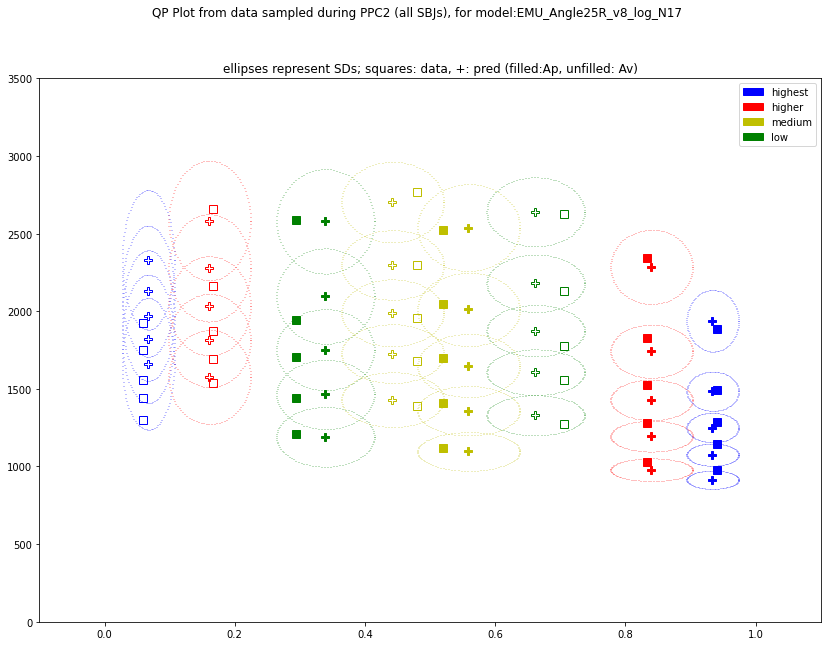

In [49]:
from math import pi
colors = ['ro','bo','go','yo']
n=4

# stuff for ellipses:
t = np.linspace(0, 2*pi, 100)

#plt.rc('lines', linewidth=0.5)
fig, ax = plt.subplots(figsize=(14,10)) #figsize: width, height

markerR1 = markers.MarkerStyle(marker='s', fillstyle='full')
markerR2 = markers.MarkerStyle(marker='s', fillstyle='none')
markerR3 = markers.MarkerStyle(marker='P', fillstyle='full')
markerR4 = markers.MarkerStyle(marker='P', fillstyle='none')
markerEllipse1 = markers.MarkerStyle(marker='_', fillstyle='full')
markerEllipse2 = markers.MarkerStyle(marker='_', fillstyle='none')

quantiles = ['q1','q3','q5','q7','q9']

alpha=0.5 # transparency of points representing ellipses
MarkerSizePoints = 8

for ind in range(n):
    col = colors[ind]
    
    for q in quantiles:
        
        ## Actual data
        ax.plot(tt_ppcDAT['FreqR1'].loc[tt_ppcDAT.index[ind]], [tt_ppcDAT[str(q)+'_R1'].loc[tt_ppcDAT.index[ind]]], 
                col, marker=markerR1,markersize=MarkerSizePoints)
        ax.plot(tt_ppcDAT['FreqR2'].loc[tt_ppcDAT.index[ind]], [tt_ppcDAT[str(q)+'_R2'].loc[tt_ppcDAT.index[ind]]], 
                col, marker=markerR2,markersize=MarkerSizePoints)

        ## For predictions
        uR1 = tt_ppcPRED['FreqR1'].loc[tt_ppcPRED.index[ind]]
        vR1 = [tt_ppcPRED[str(q)+'_R1'].loc[tt_ppcPRED.index[ind]]]
        aR1 = sdtt_ppc2PRED['FreqR1'].loc[sdtt_ppc2PRED.index[ind]]
        bR1 = sdtt_ppc2PRED[str(q)+'_R1'].loc[sdtt_ppc2PRED.index[ind]]
    
        uR2 = tt_ppcPRED['FreqR2'].loc[tt_ppcPRED.index[ind]]
        vR2 = [tt_ppcPRED[str(q)+'_R2'].loc[tt_ppcPRED.index[ind]]]
        aR2 = sdtt_ppc2PRED['FreqR2'].loc[sdtt_ppc2PRED.index[ind]]
        bR2 = sdtt_ppc2PRED[str(q)+'_R2'].loc[sdtt_ppc2PRED.index[ind]]
    
        ax.plot(tt_ppcPRED['FreqR1'].loc[tt_ppcPRED.index[ind]], [tt_ppcPRED[str(q)+'_R1'].loc[tt_ppcPRED.index[ind]]], 
                col, marker=markerR3,markersize=MarkerSizePoints)
        ax.plot(tt_ppcPRED['FreqR2'].loc[tt_ppcPRED.index[ind]], [tt_ppcPRED[str(q)+'_R2'].loc[tt_ppcPRED.index[ind]]], 
                col, marker=markerR4,markersize=MarkerSizePoints) #, markersize=20)
    
        ax.plot( uR1+aR1*np.cos(t) , vR1+bR1*np.sin(t), 
                col, marker=markerEllipse1, markersize=1, alpha=alpha) #, linestyle='--' ,linewidth=0.2
        ax.plot( uR2+aR2*np.cos(t) , vR2+bR2*np.sin(t), 
                col, marker=markerEllipse2,markersize=1, alpha=alpha)
        ax.set_xlim(-0.1,1.1)
        ax.set_ylim(0, 3500)


# Creating legend with color box
pop_b = mpatches.Patch(color='b', label='highest')
pop_a = mpatches.Patch(color='r', label='higher')
pop_d = mpatches.Patch(color='y', label='medium')
pop_c = mpatches.Patch(color='g', label='low')
plt.legend(handles=[pop_b,pop_a,pop_d,pop_c])
plt.suptitle("QP Plot from data sampled during PPC2 (all SBJs), for model:"+mOutput_name) #Title
plt.title("ellipses represent SDs; squares: data, +: pred (filled:Ap, unfilled: Av)") #Subtitle
plt.plot(figsize=(20,12),lw=10, fontsize=16, ax=ax, grid=True)
#df.plot(figsize=(20,12), title='Arctic Sea Ice Extent',
#    lw=3, fontsize=16, ax=ax, grid=True)

#### Calculate within-subject Standard Deviations (SDs)

If we calculate the within-subject standard deviation, we obtain a "cleaner" estimate for the measurement error that is due to variability in our model parameter estimates rather than due to both variability in model parameter estimates AND additional variability in estimates between subjects. This within-subject measurement error is also known as "standard error of measurement (SEM)". However, using this abbreviation might be confusing because "SEM" is also an abbreviation for "standard error of the mean" which is something else!

Therefore, simply pooling the results across subjects and then calculating the SD of errors might lead to a biased estimate of the measurement error. However, provided that we have the same number of simulations for each subject, we can actually estimate the within-subject variability by estimating the mean of the subject-specific variances in parameter estimates. 

For more details, see this source:
https://influentialpoints.com/Training/variance_and_standard_deviation-principles-properties-assumptions.htm#:~:text=Within-subject%20standard%20deviation%20%28s%20w%29%20%3D%20%E2%88%9A%20%28%CE%A3s,of%20original%20samples%2C%20or%20subjects%2C%20in%20your%20set.

In [50]:
## Calculate within-subject SD

def sdSquare(x):
   return x**2
def meanRoot(x):
   return x**0.5 #sqrt

ws_SD_bySBJ_byEvdCond = quantsByCondBySBJ_ppcPRED.groupby(['sbj','evidence_cond']).std()
ws2_SD_bySBJ_byEvdCond = ws_SD_bySBJ_byEvdCond.apply(sdSquare, axis=0) #alternative: apply(np.square)
wsM_SD_byEvdCond = ws2_SD_bySBJ_byEvdCond.groupby(['evidence_cond']).mean()
wsMR_SD_byEvdCond = wsM_SD_byEvdCond.apply(meanRoot, axis=0) #axis 0: columns, 1:rows
wsMR_SD_byEvdCond['evidence_cond'] = ['higher','highest','low','medium']
sdtt2_ppc2PRED = wsMR_SD_byEvdCond.reset_index(drop=True) 

sdtt2_ppc2PRED.head()

#ppc1c_pred_byEvdCond_sd = SD_byEvdCond[["freq_pred_R1","sim_R1_q1","sim_R1_q3","sim_R1_q5","sim_R1_q7","sim_R1_q9", 
#                                    "freq_pred_R2","sim_R2_q1","sim_R2_q3","sim_R2_q5","sim_R2_q7","sim_R2_q9"]]
#sdtt_ppc1cPRED = ppc1c_pred_byEvdCond_sd.reset_index(drop=True) 

,Unnamed: 0,sample,FreqR1,FreqR2,q1_R1,q3_R1,q5_R1,q7_R1,q9_R1,q1_R2,q3_R2,q5_R2,q7_R2,q9_R2,evidence_cond
0,1028.785692,14.28869,0.066150,0.066150,78.462209,106.127934,138.041801,179.620601,250.697983,318.963579,314.183203,333.801030,361.021449,403.499167,higher
1,1028.785692,14.28869,0.048852,0.048852,64.924177,79.338979,104.680032,137.515720,209.975679,447.462800,435.576987,440.883904,439.278144,466.241332,highest
2,1028.785692,14.28869,0.077053,0.077053,209.859524,236.479567,274.698298,325.764273,359.584957,147.171013,163.089031,179.199318,199.006945,236.041368,low
3,1028.785692,14.28869,0.079884,0.079884,131.629494,169.149406,214.952308,250.600023,304.912325,197.802130,207.785669,233.027207,240.013001,280.468700,medium


In [51]:
sdtt_ppc2PRED.head()

,Unnamed: 0,sample,FreqR1,FreqR2,q1_R1,q3_R1,q5_R1,q7_R1,q9_R1,q1_R2,q3_R2,q5_R2,q7_R2,q9_R2,evidence_cond
0,1028.785692,14.28869,0.062945,0.062945,73.105147,99.196050,130.277990,171.094545,239.170753,301.849099,299.858085,319.316025,345.539459,384.372014,higher
1,1028.785692,14.28869,0.039930,0.039930,58.848533,71.499108,94.371450,126.197085,197.993882,423.694814,413.654550,420.100714,421.491904,449.051945,highest
2,1028.785692,14.28869,0.075037,0.075037,192.505433,222.896776,260.822202,307.208346,336.266806,128.969987,146.946778,165.093079,184.624176,221.939756,low
3,1028.785692,14.28869,0.078557,0.078557,124.557871,159.276159,203.174157,236.012911,279.597950,176.209793,189.014291,215.241566,223.994082,259.726987,medium


[]

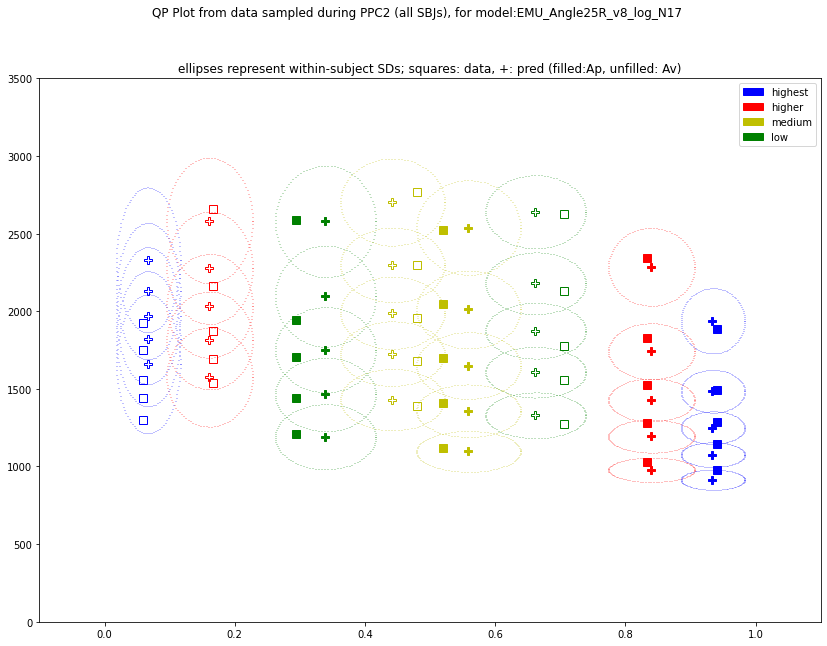

In [52]:
from math import pi
colors = ['ro','bo','go','yo']
n=4

# stuff for ellipses:
t = np.linspace(0, 2*pi, 100)

#plt.rc('lines', linewidth=0.5)
fig, ax = plt.subplots(figsize=(14,10)) #figsize: width, height

markerR1 = markers.MarkerStyle(marker='s', fillstyle='full')
markerR2 = markers.MarkerStyle(marker='s', fillstyle='none')
markerR3 = markers.MarkerStyle(marker='P', fillstyle='full')
markerR4 = markers.MarkerStyle(marker='P', fillstyle='none')
markerEllipse1 = markers.MarkerStyle(marker='_', fillstyle='full')
markerEllipse2 = markers.MarkerStyle(marker='_', fillstyle='none')

quantiles = ['q1','q3','q5','q7','q9']

alpha=0.5 # transparency of points representing ellipses
MarkerSizePoints = 8

for ind in range(n):
    col = colors[ind]
    
    for q in quantiles:
        
        ## Actual data
        ax.plot(tt_ppcDAT['FreqR1'].loc[tt_ppcDAT.index[ind]], [tt_ppcDAT[str(q)+'_R1'].loc[tt_ppcDAT.index[ind]]], 
                col, marker=markerR1,markersize=MarkerSizePoints)
        ax.plot(tt_ppcDAT['FreqR2'].loc[tt_ppcDAT.index[ind]], [tt_ppcDAT[str(q)+'_R2'].loc[tt_ppcDAT.index[ind]]], 
                col, marker=markerR2,markersize=MarkerSizePoints)

        ## For predictions
        uR1 = tt_ppcPRED['FreqR1'].loc[tt_ppcPRED.index[ind]]
        vR1 = [tt_ppcPRED[str(q)+'_R1'].loc[tt_ppcPRED.index[ind]]]
        aR1 = sdtt2_ppc2PRED['FreqR1'].loc[sdtt2_ppc2PRED.index[ind]]
        bR1 = sdtt2_ppc2PRED[str(q)+'_R1'].loc[sdtt2_ppc2PRED.index[ind]]
    
        uR2 = tt_ppcPRED['FreqR2'].loc[tt_ppcPRED.index[ind]]
        vR2 = [tt_ppcPRED[str(q)+'_R2'].loc[tt_ppcPRED.index[ind]]]
        aR2 = sdtt2_ppc2PRED['FreqR2'].loc[sdtt2_ppc2PRED.index[ind]]
        bR2 = sdtt2_ppc2PRED[str(q)+'_R2'].loc[sdtt2_ppc2PRED.index[ind]]
    
        ax.plot(tt_ppcPRED['FreqR1'].loc[tt_ppcPRED.index[ind]], [tt_ppcPRED[str(q)+'_R1'].loc[tt_ppcPRED.index[ind]]], 
                col, marker=markerR3,markersize=MarkerSizePoints)
        ax.plot(tt_ppcPRED['FreqR2'].loc[tt_ppcPRED.index[ind]], [tt_ppcPRED[str(q)+'_R2'].loc[tt_ppcPRED.index[ind]]], 
                col, marker=markerR4,markersize=MarkerSizePoints) #, markersize=20)
    
        ax.plot( uR1+aR1*np.cos(t) , vR1+bR1*np.sin(t), 
                col, marker=markerEllipse1, markersize=1, alpha=alpha) #, linestyle='--' ,linewidth=0.2
        ax.plot( uR2+aR2*np.cos(t) , vR2+bR2*np.sin(t), 
                col, marker=markerEllipse2,markersize=1, alpha=alpha)
        ax.set_xlim(-0.1,1.1)
        ax.set_ylim(0, 3500)


# Creating legend with color box
pop_b = mpatches.Patch(color='b', label='highest')
pop_a = mpatches.Patch(color='r', label='higher')
pop_d = mpatches.Patch(color='y', label='medium')
pop_c = mpatches.Patch(color='g', label='low')
plt.legend(handles=[pop_b,pop_a,pop_d,pop_c])
plt.suptitle("QP Plot from data sampled during PPC2 (all SBJs), for model:"+mOutput_name) #Title
plt.title("ellipses represent within-subject SDs; squares: data, +: pred (filled:Ap, unfilled: Av)") #Subtitle
plt.plot(figsize=(20,12),lw=10, fontsize=16, ax=ax, grid=True)
#df.plot(figsize=(20,12), title='Arctic Sea Ice Extent',
#    lw=3, fontsize=16, ax=ax, grid=True)

## Posterior Predictive Check 3 (PPC3)

### Description

This PPC consists of quantile probability plots (QPP's) of data and predictions that gives a more fine-grained analysis of potential misifts of a model. Again, we look at and simulate data based on the same reward evidence condition described above: low (0-25%), medium (25-50%), higher (50-75%), and highest (75-100%).

#### *Create Response & RT Predictions from Model*

To simulate the behavior of our model for PPC 3, we do the following: 
* Iterate through all the PPC 1 simulated data, and ***use the same reward and averse values from those PPC 1 simulation trials***. (Steps 1-2)
* Use the ***mean parameter values from the posterior distributions contained in our traces***. Note how for PPC3 we use the mean values from the posterior distribution, while in PPC1 we instead sample values from the whole posterior distribution for each parameter.

#### *Note on Parameter Definitions*

In the below code, in steps 3 and 4, you will have to manually ensure that all your parameters are defined, even if they don't vary by anything except intercept! It would be incorrect to only define the parameters that you are interested in or that you are creating interesting covariates for - don't do this!

In [ ]:
## Step 1. create dataframe to store stuff
PM_ppc_all = pd.DataFrame()

for index, row in ppc_all.iterrows():
    
    PM_ppc_low = pd.DataFrame()
    
    ## Step 2. Extract the details from "ppc_all" that was created during PPC1 (see Step 2 above)
    # (we want to use that sampled data for the QP-plot so that the PPC subplots and the QP-plot use the same data)
    # @@@ Manual adjustment necessary: define "reward"/"aversion" based on your model
    SBJ = row['sbj']
    REW = row['reward']
    AVE = row['aversion']
    CONFL = row['conflict']
    CD = row['cdDummy']
    evdCOND = row['evidence_cond']
    RESP_DAT = row['resp_data']
    RT_DAT = row['rt_data']
    
    ## Step 3. Define all Parameter names and extract means of posteriors   
    # Extract parameters of boundary separation (a)
    PM_a_I = traces['a_Intercept_subj.'+str(SBJ)].mean()
    PM_a_Icd = traces['a_conflictDomain[T.pos]_subj.'+str(SBJ)].mean()    
    PM_a_conf = traces['a_sub_conflict_subj.'+str(SBJ)].mean()
    PM_a_conf_cd = traces['a_sub_conflict:conflictDomain[T.pos]_subj.'+str(SBJ)].mean() 
    # Extract parameters of starting point (z); NOTE: INTERCEPT NEEDS TO BE TRANSFORMED BUT NOT ANY COVARIATE unless it has the ending _trans
    PM_z_raw = traces['z_Intercept_subj_trans.'+str(SBJ)].mean()
    PM_z_I = 1/(1+np.exp(-1*PM_z_raw))
    # Extract parameters for collapse of boundary (theta). Specific to angle model
    PM_thetaP = traces['theta_Intercept_subj.'+str(SBJ)].mean()
    # Extract parameters for nondecision time (t)
    PM_t = traces['t_Intercept_subj.'+str(SBJ)].mean()
    # Extract parameters for drift rates (v)
    PM_v_I = traces['v_Intercept_subj.'+str(SBJ)].mean()
    PM_v_Icd = traces['v_conflictDomain[T.pos]_subj.'+str(SBJ)].mean()
    PM_v_r = traces['v_sub_rewardLOG_subj.'+str(SBJ)].mean()
    PM_v_a = traces['v_sub_averse_subj.'+str(SBJ)].mean()
    PM_v_r_cdPmodifier = traces['v_sub_rewardLOG:conflictDomain[T.pos]_subj.'+str(SBJ)].mean()
    PM_v_a_cdPmodifier = traces['v_sub_averse:conflictDomain[T.pos]_subj.'+str(SBJ)].mean()
                    
    ## Step 4. define equation for each parameter
    # @@@ Manual adjustment necessary
    PM_V = PM_v_I + PM_v_Icd*CD + PM_v_r*REW + PM_v_r_cdPmodifier*REW*CD + PM_v_a*AVE + PM_v_a_cdPmodifier*AVE*CD
    PM_V = PM_V.astype('float64')  
    PM_a = PM_a_I + PM_a_Icd*CD + PM_a_conf*CONFL + PM_a_conf_cd*CONFL*CD
    PM_a = PM_a.astype('float64')
    PM_z = PM_z_I
    PM_z = PM_z.astype('float64')
    PM_t = PM_t
    PM_t = PM_t.astype('float64')
    PM_thetaP = PM_thetaP
    PM_thetaP = PM_thetaP.astype('float64')
   
    ## Step 5. form the required parameter vector to generate predictions
    # check the sequence of parameters for each model to feed into (see detailed notes in PPC1 in corresponding step)
    PM_params_temp = [PM_V, PM_a, PM_z, PM_t, PM_thetaP]  

    ## Step 6a. generate predictions
    PM_out = simulator(model = model,
                       theta = PM_params_temp,
                       n_samples = 1,
                       delta_t = 0.001) 
    
    PM_rt_pred = PM_out[0][0].astype('float64')  
    PM_resp_pred = PM_out[1][0]


    ## Step 7. store stuff in newly created pandas dataframe that we can then use later
    PM_ppc_low = pd.DataFrame({'sbj': [sbj],
                               'reward': [REW],
                               'aversion': [AVE],
                               'conflict': [CONFL],
                               'cd_dummy': [CD],
                               'resp_data': [RESP_DAT],
                               'rt_data': [RT_DAT],
                                'resp_pred': [1*(PM_resp_pred[0]>0)],
                               'rt_pred': [np.sign(PM_resp_pred[0])*PM_rt_pred[0]],
                               'evidence_cond':evdCOND})
    
    
    ## append the stuff 
    #print('subject is:',sbj)
    PM_ppc_all = PM_ppc_all.append(PM_ppc_low,ignore_index=True)
            #lst.append([sample])


# store it
PM_ppc_all.to_csv('./'+project+'_'+mOutput_name+'_ppc3_byEvdCond.csv')
# PM_ppc_all.head()

In [54]:
## in case you have already run the simulation above and stored the csv file, you can use this now:
PM_ppc_all = hddm.load_csv('./'+project+'_'+mOutput_name+'_ppc3_byEvdCond.csv')
PM_ppc_all.head() 

,Unnamed: 0,sbj,reward,aversion,conflict,cd_dummy,resp_data,rt_data,resp_pred,rt_pred,evidence_cond
0,0,164,-1.270536,0.976349,-0.535465,0.0,1,1.801,1,2.379426,low
1,1,164,-1.270536,0.976349,-0.535465,0.0,0,-2.070,0,-3.266383,low
2,2,164,-1.270536,0.594901,-0.136301,0.0,1,1.520,0,-1.577388,low
3,3,164,-1.270536,0.976349,-0.535465,0.0,0,-1.697,0,-1.536388,low
4,4,164,-1.270536,0.976349,-0.535465,0.0,0,-2.350,1,2.709424,low


### Plotting Results of Posterior Predictive Check 3

In [55]:
# for each subject, calculate the quantiles for each RelRewEvid-condition:
evd_conds=['low','medium','higher','highest']

subjs=np.unique(np.array(PM_ppc_all.sbj))
quantsByCondBySBJ_ppcDAT = pd.DataFrame()
quantsByCondBySBJ_ppcPRED = pd.DataFrame()

# convert RT measure into milliseconds and get rid of sign:
PM_ppc_all['rtp_data'] = abs(PM_ppc_all['rt_data'])*1000
PM_ppc_all['rtp_pred'] = abs(PM_ppc_all['rt_pred'])*1000


###### Calculate quantiles for sampled data:


for evidence_cond in evd_conds:
    for sbj in subjs:
        
        ## Step 1. select the subject and the condition
        df=PM_ppc_all[PM_ppc_all.sbj==sbj]
        dfsub = df[df.evidence_cond==evidence_cond].reset_index(drop=True)
        ntrials = dfsub.shape[0] #nr of obs. for that subject and that condition
        aux = pd.DataFrame()
        
        ## Step 2. subset data by response type
        dfsub_R1 = dfsub[dfsub.resp_data==1].reset_index(drop=True) # response type 1: decisions towards upper boundary
        dfsub_R2 = dfsub[dfsub.resp_data==0].reset_index(drop=True) # response type 2: decisions towards lower boundary
        
        ## Step 3. calculate quantiles for each subset
        if not dfsub_R1.empty:
            Freq_R1 = dfsub_R1.shape[0]/ntrials #nr of rows
            q1_R1 = np.percentile(dfsub_R1['rtp_data'], 10)
            q3_R1 = np.percentile(dfsub_R1['rtp_data'], 30)
            q5_R1 = np.percentile(dfsub_R1['rtp_data'], 50)
            q7_R1 = np.percentile(dfsub_R1['rtp_data'], 70)
            q9_R1 = np.percentile(dfsub_R1['rtp_data'], 90)
        else: # if subject does not have any responses in response category 1
            Freq_R1 = 0
            q1_R1 = np.nan
            q3_R1 = np.nan
            q5_R1 = np.nan
            q7_R1 = np.nan
            q9_R1 = np.nan
            
        if not dfsub_R2.empty:
            Freq_R2 = dfsub_R2.shape[0]/ntrials #nr of rows
            q1_R2 = np.percentile(dfsub_R2['rtp_data'], 10)
            q3_R2 = np.percentile(dfsub_R2['rtp_data'], 30)
            q5_R2 = np.percentile(dfsub_R2['rtp_data'], 50)
            q7_R2 = np.percentile(dfsub_R2['rtp_data'], 70)
            q9_R2 = np.percentile(dfsub_R2['rtp_data'], 90)
        else: # if subject does not have any responses in response category 1
            Freq_R2 = 0
            q1_R2 = np.nan
            q3_R2 = np.nan
            q5_R2 = np.nan
            q7_R2 = np.nan
            q9_R2 = np.nan
        
        ## Step 4. store stuff in newly created pandas dataframe that we can then use later
        aux = pd.DataFrame({'sbj': [sbj],
                            'evidence_cond': evidence_cond,
                            'FreqR1':Freq_R1,
                            'FreqR2':Freq_R2,
                            'q1_R1': q1_R1,
                            'q3_R1': q3_R1,
                            'q5_R1': q5_R1,
                            'q7_R1': q7_R1,
                            'q9_R1': q9_R1,
                            'q1_R2': q1_R2,
                            'q3_R2': q3_R2,
                            'q5_R2': q5_R2,
                            'q7_R2': q7_R2,
                            'q9_R2': q9_R2})
       
        ## Step 5. append the stuff 
        #print('subject is:',sbj)
        quantsByCondBySBJ_ppcDAT = quantsByCondBySBJ_ppcDAT.append(aux,ignore_index=True)



        
###### Calculate quantiles for sampled predictions:

for evidence_cond in evd_conds:
    for sbj in subjs:
        ## Step 1. select the subject and the condition
        df=PM_ppc_all[PM_ppc_all.sbj==sbj]
        dfsub = df[df.evidence_cond==evidence_cond].reset_index(drop=True)
        ntrials = dfsub.shape[0] #nr of obs. for that subject and that condition
        aux_pred = pd.DataFrame()
        
        ## Step 2. subset data by response type
        dfsub_R1 = dfsub[dfsub.resp_pred==1].reset_index(drop=True) # approach decisions
        dfsub_R2 = dfsub[dfsub.resp_pred==0].reset_index(drop=True) # avoid decisions
        
        ## Step 3. calculate quantiles for each subset
        if not dfsub_R1.empty:
            Freq_R1 = dfsub_R1.shape[0]/ntrials #nr of rows
            q1_R1 = np.percentile(dfsub_R1['rtp_pred'], 10)
            q3_R1 = np.percentile(dfsub_R1['rtp_pred'], 30)
            q5_R1 = np.percentile(dfsub_R1['rtp_pred'], 50)
            q7_R1 = np.percentile(dfsub_R1['rtp_pred'], 70)
            q9_R1 = np.percentile(dfsub_R1['rtp_pred'], 90)
        else:
            Freq_R1 = 0
            q1_R1 = np.nan
            q3_R1 = np.nan
            q5_R1 = np.nan
            q7_R1 = np.nan
            q9_R1 = np.nan
            
        if not dfsub_R2.empty:
            Freq_R2 = dfsub_R2.shape[0]/ntrials #nr of rows
            q1_R2 = np.percentile(dfsub_R2['rtp_pred'], 10)
            q3_R2 = np.percentile(dfsub_R2['rtp_pred'], 30)
            q5_R2 = np.percentile(dfsub_R2['rtp_pred'], 50)
            q7_R2 = np.percentile(dfsub_R2['rtp_pred'], 70)
            q9_R2 = np.percentile(dfsub_R2['rtp_pred'], 90)
        else:
            Freq_R2 = 0
            q1_R2 = np.nan
            q3_R2 = np.nan
            q5_R2 = np.nan
            q7_R2 = np.nan
            q9_R2 = np.nan
        
        ## Step 4. store stuff in newly created pandas dataframe that we can then use later
        aux_pred = pd.DataFrame({'sbj': [sbj],
                                 'evidence_cond': evidence_cond,
                                 'FreqR1':Freq_R1,
                                 'FreqR2':Freq_R2,
                                 'q1_R1': q1_R1,
                                 'q3_R1': q3_R1,
                                 'q5_R1': q5_R1,
                                 'q7_R1': q7_R1,
                                 'q9_R1': q9_R1,
                                 'q1_R2': q1_R2,
                                 'q3_R2': q3_R2,
                                 'q5_R2': q5_R2,
                                 'q7_R2': q7_R2,
                                 'q9_R2': q9_R2})
            
        ## Step 5. append the stuff 
        #print('subject is:',sbj)
        quantsByCondBySBJ_ppcPRED = quantsByCondBySBJ_ppcPRED.append(aux_pred,ignore_index=True)
    


In [56]:
quantsByCondBySBJ_ppcPRED.head()

,sbj,evidence_cond,FreqR1,FreqR2,q1_R1,q3_R1,q5_R1,q7_R1,q9_R1,q1_R2,q3_R2,q5_R2,q7_R2,q9_R2
0,164,low,0.326222,0.673778,1018.886507,1354.548931,1732.837319,2204.049945,2940.536618,1127.980614,1449.348664,1771.782994,2155.923080,2815.168262
1,164,medium,0.549667,0.450333,1002.593136,1306.441259,1635.663509,2073.962593,2774.957609,1156.323504,1539.968991,1892.403007,2329.112625,2975.886250
2,164,higher,0.846111,0.153889,878.042400,1140.898228,1398.940086,1771.690607,2448.625374,1196.351409,1654.044867,2040.732384,2469.547176,3023.126936
3,164,highest,0.938667,0.061333,838.059783,1019.000256,1206.066966,1466.702473,2073.103809,1135.306454,1563.024282,1961.722553,2437.420607,3044.066644


In [57]:

###### do the plotting

quantsByCond_ppcDAT = quantsByCondBySBJ_ppcDAT.groupby(['evidence_cond']).mean() #.reset_index(name='evidence_cond')
quantsByCond_ppcDAT['evidence_cond'] = ['higher','highest','low','medium']
tt_ppcDAT = quantsByCond_ppcDAT.reset_index(drop=True) 


quantsByCond_ppcPRED = quantsByCondBySBJ_ppcPRED.groupby(['evidence_cond']).mean() #.reset_index(name='evidence_cond')
quantsByCond_ppcPRED['evidence_cond'] = ['higher','highest','low','medium']
tt_ppcPRED = quantsByCond_ppcPRED.reset_index(drop=True) 
        

quantsByCond_ppcPRED.head()
  

,sbj,FreqR1,FreqR2,q1_R1,q3_R1,q5_R1,q7_R1,q9_R1,q1_R2,q3_R2,q5_R2,q7_R2,q9_R2,evidence_cond
evidence_cond,,,,,,,,,,,,,,
higher,164,0.846111,0.153889,878.042400,1140.898228,1398.940086,1771.690607,2448.625374,1196.351409,1654.044867,2040.732384,2469.547176,3023.126936,higher
highest,164,0.938667,0.061333,838.059783,1019.000256,1206.066966,1466.702473,2073.103809,1135.306454,1563.024282,1961.722553,2437.420607,3044.066644,highest
low,164,0.326222,0.673778,1018.886507,1354.548931,1732.837319,2204.049945,2940.536618,1127.980614,1449.348664,1771.782994,2155.923080,2815.168262,low
medium,164,0.549667,0.450333,1002.593136,1306.441259,1635.663509,2073.962593,2774.957609,1156.323504,1539.968991,1892.403007,2329.112625,2975.886250,medium


### Plot with point predictions only (based on posterior means)

Text(0.5, 1.0, '(all SBJs), squares: data, +: pred (filled:Ap, unfilled: Av)')

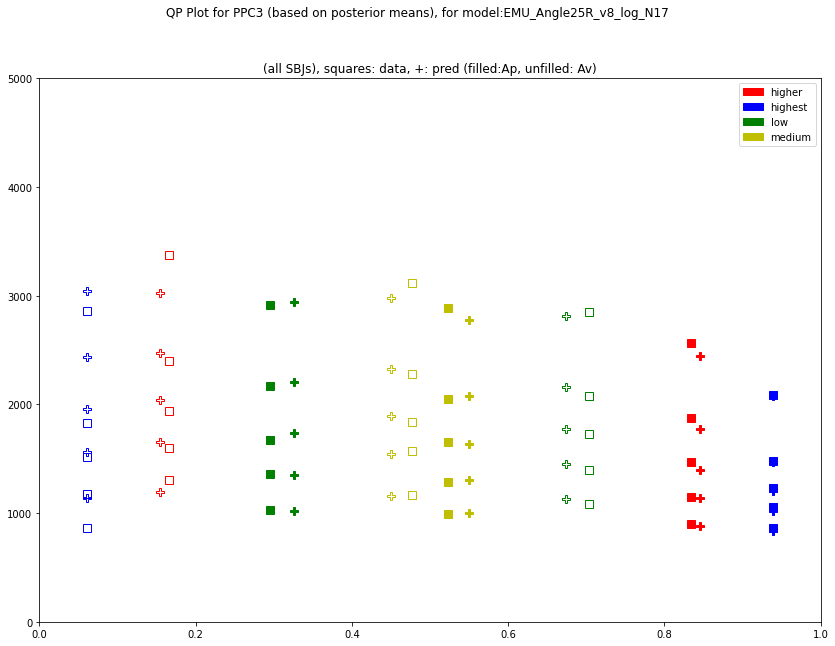

In [58]:

colors = ['ro','bo','go','yo']
n=4

fig, ax = plt.subplots(figsize=(14,10)) #figsize: width, height
markerR1 = markers.MarkerStyle(marker='s', fillstyle='full')
markerR2 = markers.MarkerStyle(marker='s', fillstyle='none')
markerR3 = markers.MarkerStyle(marker='P', fillstyle='full')
markerR4 = markers.MarkerStyle(marker='P', fillstyle='none')

MarkerSizePoints = 8

quantiles = ['q1','q3','q5','q7','q9']

for ind in range(n):
    col = colors[ind]
    
    for q in quantiles:
        ax.plot(tt_ppcDAT['FreqR1'].loc[tt_ppcDAT.index[ind]], [tt_ppcDAT[str(q)+'_R1'].loc[tt_ppcDAT.index[ind]]], 
                col, marker=markerR1, markersize=MarkerSizePoints)
        ax.plot(tt_ppcDAT['FreqR2'].loc[tt_ppcDAT.index[ind]], [tt_ppcDAT[str(q)+'_R2'].loc[tt_ppcDAT.index[ind]]], 
                col, marker=markerR2, markersize=MarkerSizePoints)
        # Predictions
        ax.plot(tt_ppcPRED['FreqR1'].loc[tt_ppcPRED.index[ind]], [tt_ppcPRED[str(q)+'_R1'].loc[tt_ppcPRED.index[ind]]], 
                col, marker=markerR3, markersize=MarkerSizePoints)
        ax.plot(tt_ppcPRED['FreqR2'].loc[tt_ppcPRED.index[ind]], [tt_ppcPRED[str(q)+'_R2'].loc[tt_ppcPRED.index[ind]]], 
                col, marker=markerR4, markersize=MarkerSizePoints)

        ax.set_xlim(0,1)
        ax.set_ylim(0, 5000)

# Creating legend with color box
pop_a = mpatches.Patch(color='r', label='higher')
pop_b = mpatches.Patch(color='b', label='highest')
pop_c = mpatches.Patch(color='g', label='low')
pop_d = mpatches.Patch(color='y', label='medium')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d])
plt.suptitle("QP Plot for PPC3 (based on posterior means), for model:"+mOutput_name) #Title
plt.title("(all SBJs), squares: data, +: pred (filled:Ap, unfilled: Av)") #Subtitle
